# Task 2 — Exploratory Data Analysis (EDA)
This notebook analyzes Ethiopia’s financial inclusion dataset to understand patterns and potential drivers of:

- **ACCESS**: Account Ownership (Findex definition)
- **USAGE**: Digital Payments / Mobile Money usage proxies

It produces:
- Dataset overview + data quality assessment
- Temporal coverage visualization
- Access trajectory + growth rates + gender gap
- Usage trends + registered vs active gaps + payments mix (P2P vs ATM)
- Infrastructure/enablers analysis (4G, mobile penetration, affordability, Fayda)
- Event timeline overlays
- Correlation analysis across indicators
- A written summary of key insights & limitations


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_FILE = Path("../data/processed/ethiopia_fi_unified_data_enriched.csv")
if not DATA_FILE.exists():
    # fallback to raw if processed not created yet
    DATA_FILE = Path("../data/raw/ethiopia_fi_unified_data.csv")

df = pd.read_csv(DATA_FILE)
print("Loaded:", DATA_FILE, "shape:", df.shape)

# Parse date fields if present
for c in ["observation_date","period_start","period_end"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df.head()


Loaded: ..\data\raw\ethiopia_fi_unified_data.csv shape: (43, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


In [2]:
# Helpers
def is_nullish(x):
    return pd.isna(x) or str(x).strip()==""

def year_from_date(s):
    if pd.isna(s):
        return np.nan
    return s.year

df["year"] = df["observation_date"].apply(year_from_date) if "observation_date" in df.columns else np.nan


## 1) Dataset Overview

In [3]:
# Summarize by record_type, pillar, source_type
display(df["record_type"].value_counts(dropna=False))

if "pillar" in df.columns:
    display(pd.crosstab(df["record_type"], df["pillar"], dropna=False))

if "source_type" in df.columns:
    display(df["source_type"].value_counts(dropna=False))


record_type
observation    30
event          10
target          3
Name: count, dtype: int64

pillar,ACCESS,AFFORDABILITY,GENDER,USAGE,NaN
record_type,,,,,
event,0,0,0,0,10
observation,14,1,4,11,0
target,2,0,1,0,0


source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

In [4]:
# Data quality: confidence distribution
if "confidence" in df.columns:
    display(df["confidence"].value_counts(dropna=False))


confidence
high      40
medium     3
Name: count, dtype: int64

## 2) Temporal Coverage Visualization

In [5]:
# Coverage heatmap-like table: years x indicator_code (count of observations)
obs = df[df["record_type"]=="observation"].copy()

coverage = (obs.groupby(["indicator_code","year"]).size()
            .reset_index(name="n")
            .pivot(index="indicator_code", columns="year", values="n")
            .fillna(0)
            .astype(int))

coverage.head(30)


year,2014,2017,2021,2023,2024,2025
indicator_code,,,,,,
ACC_4G_COV,0,0,0,1,0,1
ACC_FAYDA,0,0,0,0,1,2
ACC_MM_ACCOUNT,0,0,1,0,1,0
ACC_MOBILE_PEN,0,0,0,0,0,1
ACC_OWNERSHIP,1,1,3,0,1,0
AFF_DATA_INCOME,0,0,0,0,1,0
GEN_GAP_ACC,0,0,1,0,1,0
GEN_GAP_MOBILE,0,0,0,0,1,0
GEN_MM_SHARE,0,0,0,0,1,0


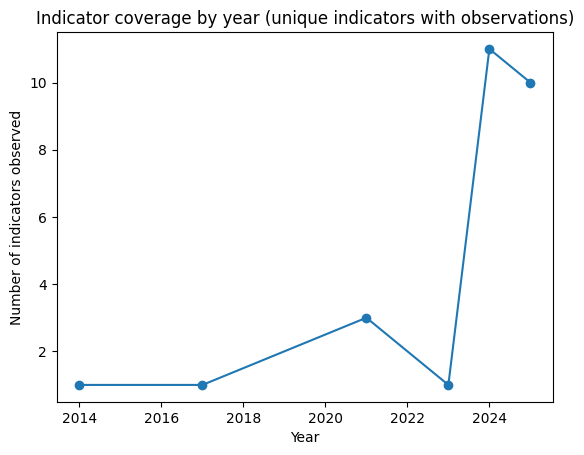

In [6]:
# Plot: number of indicators available each year
indicators_per_year = (obs.dropna(subset=["year"])
                       .groupby("year")["indicator_code"]
                       .nunique()
                       .sort_index())

plt.figure()
plt.plot(indicators_per_year.index, indicators_per_year.values, marker="o")
plt.title("Indicator coverage by year (unique indicators with observations)")
plt.xlabel("Year")
plt.ylabel("Number of indicators observed")
plt.show()


In [7]:
# Identify sparse indicators (<=2 data points)
indicator_counts = obs["indicator_code"].value_counts()
sparse = indicator_counts[indicator_counts <= 2]
sparse.head(30), sparse.shape[0]


(indicator_code
 ACC_MM_ACCOUNT        2
 ACC_4G_COV            2
 USG_P2P_COUNT         2
 GEN_GAP_ACC           2
 ACC_MOBILE_PEN        1
 USG_P2P_VALUE         1
 USG_ATM_COUNT         1
 USG_ATM_VALUE         1
 USG_CROSSOVER         1
 USG_TELEBIRR_USERS    1
 USG_TELEBIRR_VALUE    1
 USG_MPESA_USERS       1
 USG_MPESA_ACTIVE      1
 USG_ACTIVE_RATE       1
 AFF_DATA_INCOME       1
 GEN_MM_SHARE          1
 GEN_GAP_MOBILE        1
 Name: count, dtype: int64,
 17)

## 3) ACCESS Analysis — Account Ownership

,year,value_numeric,gender,location,source_name,confidence,notes
0,2014,22.0,all,national,Global Findex 2014,high,NaN
1,2017,35.0,all,national,Global Findex 2017,high,NaN
2,2021,46.0,all,national,Global Findex 2021,high,NaN
3,2021,56.0,male,national,Global Findex 2021,high,NaN
4,2021,36.0,female,national,Global Findex 2021,high,NaN
5,2024,49.0,all,national,Global Findex 2024,high,NaN


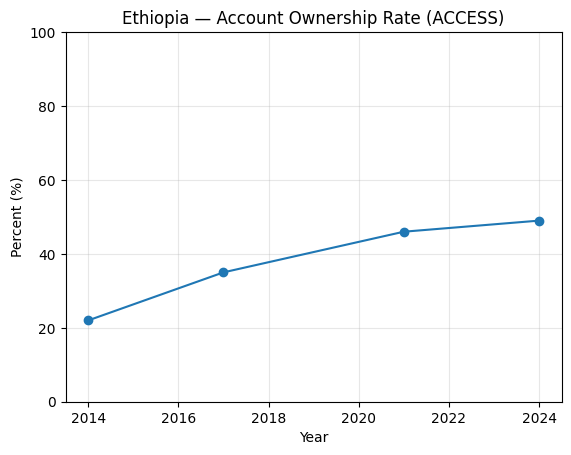

In [8]:
# Account ownership trajectory (ACC_OWNERSHIP)
acc = obs[obs["indicator_code"]=="ACC_OWNERSHIP"].copy()
acc = acc.sort_values("observation_date")

display(acc[["year","value_numeric","gender","location","source_name","confidence","notes"]].head(20))

# National / all
acc_nat = acc[(acc["gender"].fillna("all")=="all") & (acc["location"].fillna("national")=="national")].copy()
acc_nat = acc_nat.sort_values("year")

plt.figure()
plt.plot(acc_nat["year"], acc_nat["value_numeric"], marker="o")
plt.title("Ethiopia — Account Ownership Rate (ACCESS)")
plt.xlabel("Year")
plt.ylabel("Percent (%)")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# Growth rates between survey years (percentage-point changes)
acc_nat["pp_change"] = acc_nat["value_numeric"].diff()
acc_nat["years_between"] = acc_nat["year"].diff()
acc_nat["pp_per_year"] = acc_nat["pp_change"] / acc_nat["years_between"]

acc_nat[["year","value_numeric","pp_change","pp_per_year"]]


,year,value_numeric,pp_change,pp_per_year
0,2014,22.0,NaN,NaN
1,2017,35.0,13.0,4.333333
2,2021,46.0,11.0,2.750000
5,2024,49.0,3.0,1.000000


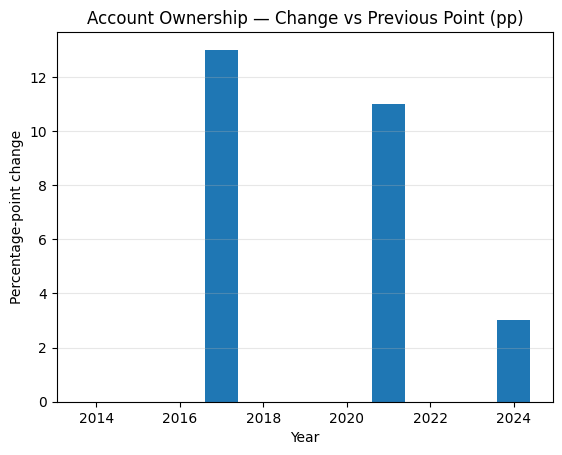

In [10]:
# Visualize pp changes
plt.figure()
plt.bar(acc_nat["year"].astype(int), acc_nat["pp_change"].fillna(0))
plt.title("Account Ownership — Change vs Previous Point (pp)")
plt.xlabel("Year")
plt.ylabel("Percentage-point change")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


gender,female,male,gap_pp
year,,,
2021,36.0,56.0,20.0


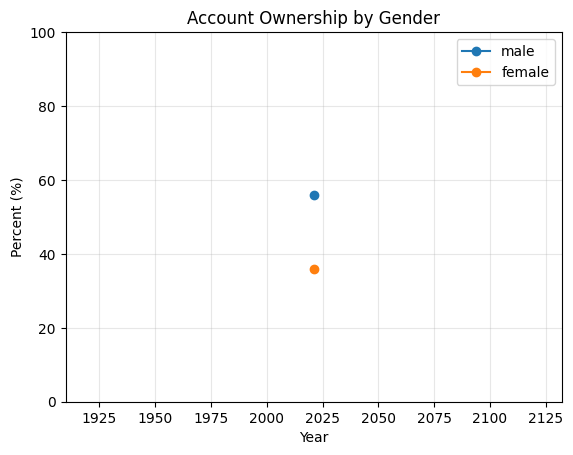

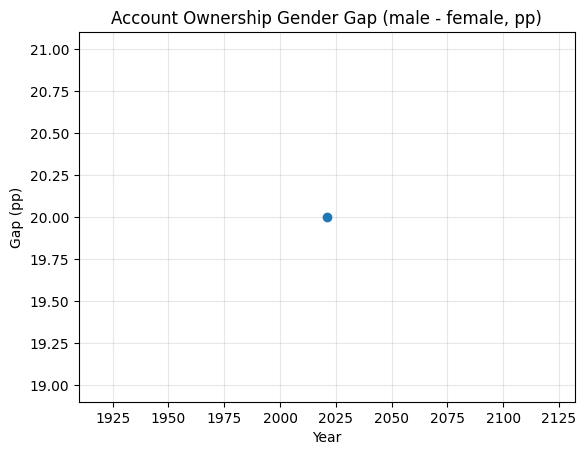

In [11]:
# Gender gap analysis (if available)
acc_gender = acc[(acc["year"].notna()) & (acc["gender"].isin(["male","female"]))].copy()
if not acc_gender.empty:
    acc_gender_p = acc_gender.pivot_table(index="year", columns="gender", values="value_numeric", aggfunc="mean").sort_index()
    acc_gender_p["gap_pp"] = acc_gender_p.get("male") - acc_gender_p.get("female")
    display(acc_gender_p)

    plt.figure()
    plt.plot(acc_gender_p.index, acc_gender_p["male"], marker="o", label="male")
    plt.plot(acc_gender_p.index, acc_gender_p["female"], marker="o", label="female")
    plt.title("Account Ownership by Gender")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(acc_gender_p.index, acc_gender_p["gap_pp"], marker="o")
    plt.title("Account Ownership Gender Gap (male - female, pp)")
    plt.xlabel("Year")
    plt.ylabel("Gap (pp)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No gender-disaggregated account ownership rows found.")


### Interpreting the 2021–2024 slowdown
Use this section to discuss why account ownership rose only +3pp.

,year,acc_ownership,mm_account_rate
0,2014,22.0,NaN
1,2017,35.0,NaN
2,2021,46.0,4.70
3,2024,49.0,9.45


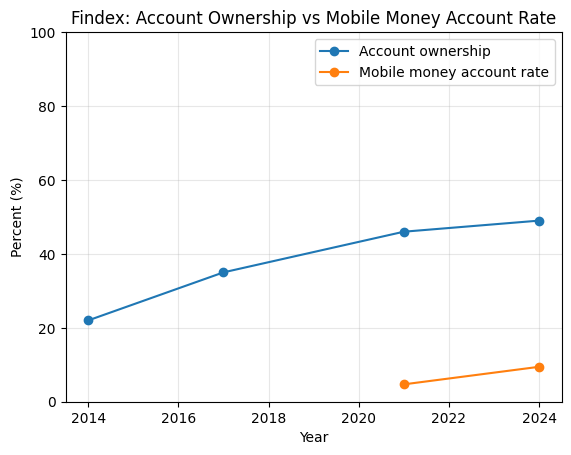

In [12]:
# Compare account ownership vs mobile money account rate (survey)
mm = obs[obs["indicator_code"]=="ACC_MM_ACCOUNT"].copy().sort_values("year")

if not mm.empty and not acc_nat.empty:
    merged = pd.merge(acc_nat[["year","value_numeric"]].rename(columns={"value_numeric":"acc_ownership"}),
                      mm[["year","value_numeric"]].rename(columns={"value_numeric":"mm_account_rate"}),
                      on="year", how="outer").sort_values("year")
    display(merged)

    plt.figure()
    plt.plot(merged["year"], merged["acc_ownership"], marker="o", label="Account ownership")
    plt.plot(merged["year"], merged["mm_account_rate"], marker="o", label="Mobile money account rate")
    plt.title("Findex: Account Ownership vs Mobile Money Account Rate")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("Mobile money account rate (ACC_MM_ACCOUNT) or account ownership data missing.")


## 4) USAGE Analysis — Digital payments and mobile money activity proxies

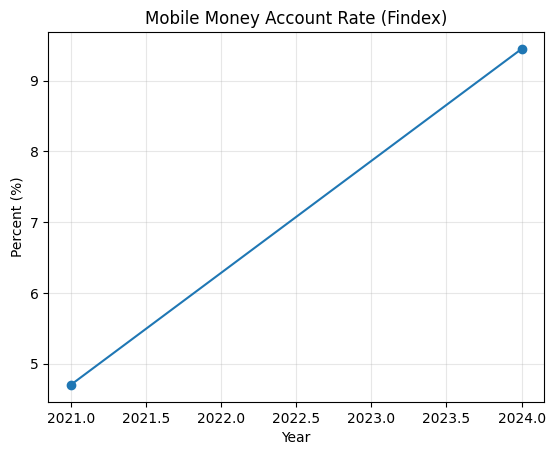

In [13]:
# Mobile money penetration trend from Findex (ACC_MM_ACCOUNT)
if not mm.empty:
    plt.figure()
    plt.plot(mm["year"], mm["value_numeric"], marker="o")
    plt.title("Mobile Money Account Rate (Findex)")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.grid(True, alpha=0.3)
    plt.show()


,year,registered,active_90d,active_rate_pct
0,2024,10800000.0,7100000.0,65.740741


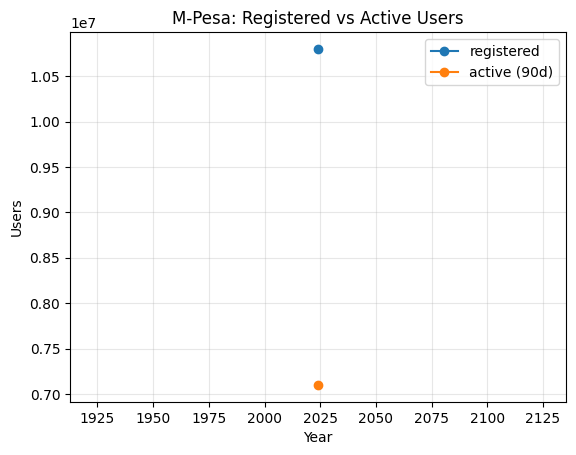

In [14]:
# Registered vs active gap for M-Pesa (USG_MPESA_USERS vs USG_MPESA_ACTIVE), if present
reg = obs[obs["indicator_code"]=="USG_MPESA_USERS"].copy()
act = obs[obs["indicator_code"]=="USG_MPESA_ACTIVE"].copy()

if not reg.empty and not act.empty:
    m = pd.merge(reg[["year","value_numeric"]].rename(columns={"value_numeric":"registered"}),
                 act[["year","value_numeric"]].rename(columns={"value_numeric":"active_90d"}),
                 on="year", how="inner").sort_values("year")
    m["active_rate_pct"] = (m["active_90d"] / m["registered"]) * 100
    display(m)

    plt.figure()
    plt.plot(m["year"], m["registered"], marker="o", label="registered")
    plt.plot(m["year"], m["active_90d"], marker="o", label="active (90d)")
    plt.title("M-Pesa: Registered vs Active Users")
    plt.xlabel("Year")
    plt.ylabel("Users")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("M-Pesa registered/active indicators not found (USG_MPESA_USERS / USG_MPESA_ACTIVE).")


,year,p2p_txn,atm_txn,p2p_over_atm
0,2024,49700000.0,NaN,NaN
1,2025,128300000.0,119300000.0,1.07544


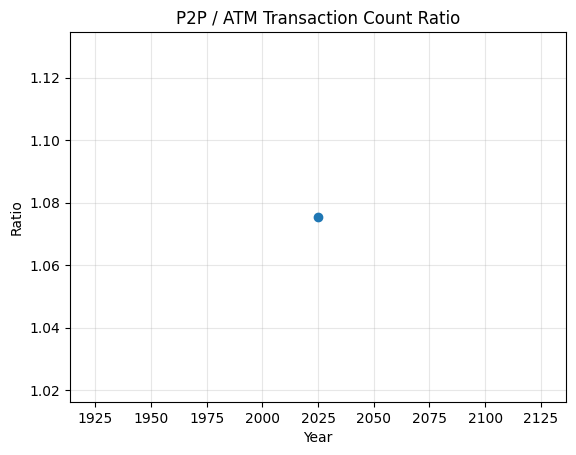

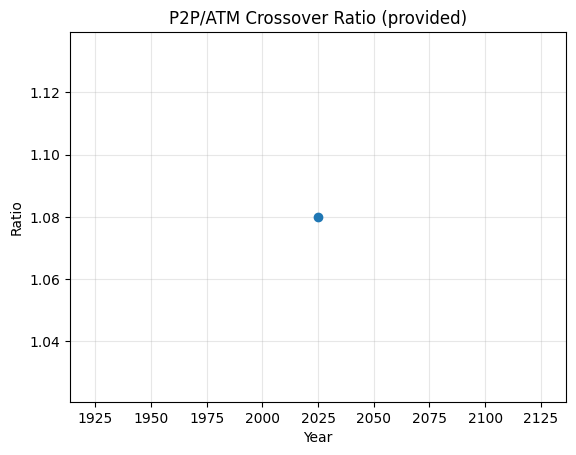

In [15]:
# Payments mix proxy: P2P vs ATM counts (USG_P2P_COUNT vs USG_ATM_COUNT) and crossover ratio (USG_CROSSOVER)
p2p = obs[obs["indicator_code"]=="USG_P2P_COUNT"].copy().sort_values("year")
atm = obs[obs["indicator_code"]=="USG_ATM_COUNT"].copy().sort_values("year")
cross = obs[obs["indicator_code"]=="USG_CROSSOVER"].copy().sort_values("year")

if not p2p.empty and not atm.empty:
    p = pd.merge(p2p[["year","value_numeric"]].rename(columns={"value_numeric":"p2p_txn"}),
                 atm[["year","value_numeric"]].rename(columns={"value_numeric":"atm_txn"}),
                 on="year", how="outer").sort_values("year")
    p["p2p_over_atm"] = p["p2p_txn"] / p["atm_txn"]
    display(p)

    plt.figure()
    plt.plot(p["year"], p["p2p_over_atm"], marker="o")
    plt.title("P2P / ATM Transaction Count Ratio")
    plt.xlabel("Year")
    plt.ylabel("Ratio")
    plt.grid(True, alpha=0.3)
    plt.show()

if not cross.empty:
    plt.figure()
    plt.plot(cross["year"], cross["value_numeric"], marker="o")
    plt.title("P2P/ATM Crossover Ratio (provided)")
    plt.xlabel("Year")
    plt.ylabel("Ratio")
    plt.grid(True, alpha=0.3)
    plt.show()


## 5) Infrastructure & Enablers

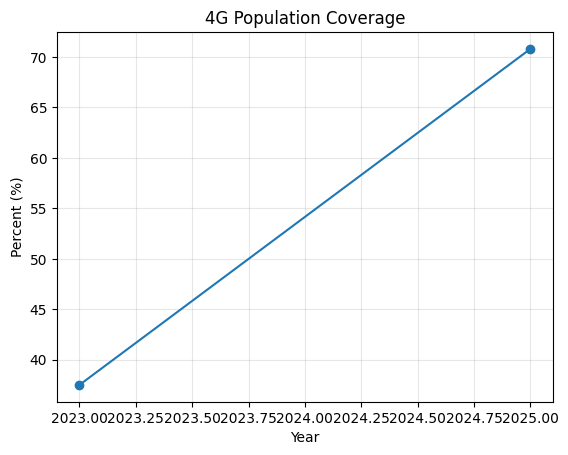

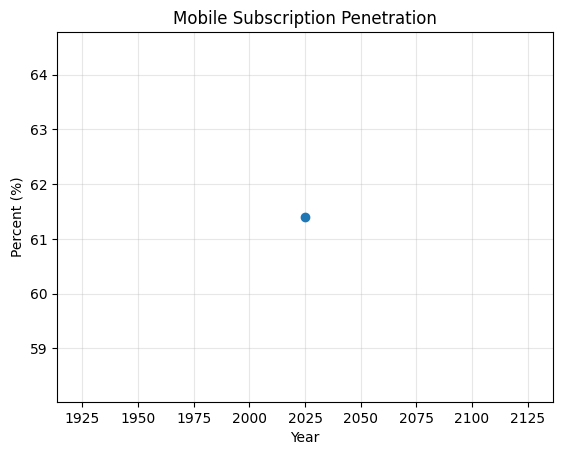

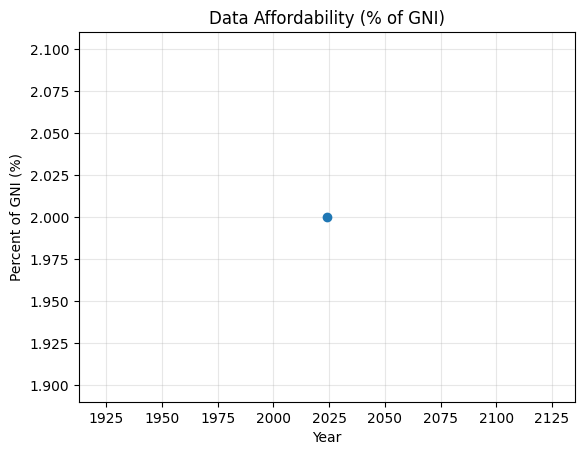

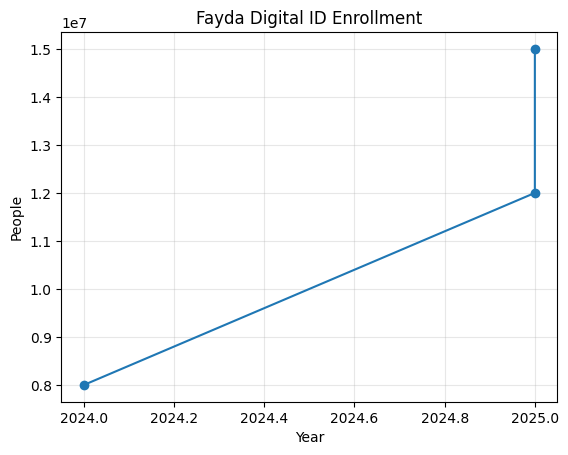

,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year
11,REC_0012,observation,NaN,ACCESS,Fayda Digital ID Enrollment,ACC_FAYDA,higher_better,8000000.0,NaN,count,people,2024-08-15,NaT,NaT,2024,all,national,NaN,Fayda Official,regulator,https://www.id.gov.et/,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2024
12,REC_0013,observation,NaN,ACCESS,Fayda Digital ID Enrollment,ACC_FAYDA,higher_better,12000000.0,NaN,count,people,2025-02-28,NaT,NaT,2025,all,national,NaN,World Bank,research,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,Over 12 million registered as of February 2025,NaN,NaN,2025
13,REC_0014,observation,NaN,ACCESS,Fayda Digital ID Enrollment,ACC_FAYDA,higher_better,15000000.0,NaN,count,people,2025-05-15,NaT,NaT,2025,all,national,NaN,ID4Africa Conference,regulator,https://www.id.gov.et/,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2025


In [16]:
# Example enablers present in your data: 4G coverage, mobile penetration, affordability, Fayda ID enrollment
def plot_indicator(code, title=None, y_label=None):
    d = obs[obs["indicator_code"]==code].copy().sort_values("year")
    if d.empty:
        print("Missing:", code)
        return None
    plt.figure()
    plt.plot(d["year"], d["value_numeric"], marker="o")
    plt.title(title or code)
    plt.xlabel("Year")
    plt.ylabel(y_label or "")
    plt.grid(True, alpha=0.3)
    plt.show()
    return d

plot_indicator("ACC_4G_COV", "4G Population Coverage", "Percent (%)")
plot_indicator("ACC_MOBILE_PEN", "Mobile Subscription Penetration", "Percent (%)")
plot_indicator("AFF_DATA_INCOME", "Data Affordability (% of GNI)", "Percent of GNI (%)")
plot_indicator("ACC_FAYDA", "Fayda Digital ID Enrollment", "People")


In [17]:
# Relationship exploration (simple scatter): Access vs 4G coverage where years overlap
acc_nat2 = acc_nat[["year","value_numeric"]].rename(columns={"value_numeric":"acc_ownership"})
cov4g = obs[obs["indicator_code"]=="ACC_4G_COV"][["year","value_numeric"]].rename(columns={"value_numeric":"cov4g"})
mobpen = obs[obs["indicator_code"]=="ACC_MOBILE_PEN"][["year","value_numeric"]].rename(columns={"value_numeric":"mobile_pen"})

tmp = acc_nat2.merge(cov4g, on="year", how="inner").merge(mobpen, on="year", how="left")
display(tmp)

if not tmp.empty:
    plt.figure()
    plt.scatter(tmp["cov4g"], tmp["acc_ownership"])
    plt.title("Account Ownership vs 4G Coverage (overlapping years)")
    plt.xlabel("4G Coverage (%)")
    plt.ylabel("Account Ownership (%)")
    plt.grid(True, alpha=0.3)
    plt.show()


,year,acc_ownership,cov4g,mobile_pen


## 6) Event Timeline & Overlays

,record_id,category,indicator,indicator_code,value_text,event_date,source_name,confidence
0,EVT_0001,product_launch,Telebirr Launch,EVT_TELEBIRR,Launched,2021-05-17,Ethio Telecom,high
1,EVT_0009,policy,NFIS-II Strategy Launch,EVT_NFIS2,Launched,2021-09-01,NBE,high
2,EVT_0002,market_entry,Safaricom Ethiopia Commercial Launch,EVT_SAFARICOM,Launched,2022-08-01,News,high
3,EVT_0003,product_launch,M-Pesa Ethiopia Launch,EVT_MPESA,Launched,2023-08-01,Safaricom,high
4,EVT_0004,infrastructure,Fayda Digital ID Program Rollout,EVT_FAYDA,Launched,2024-01-01,NIDP,high
5,EVT_0005,policy,Foreign Exchange Liberalization,EVT_FX_REFORM,Implemented,2024-07-29,NBE,high
6,EVT_0006,milestone,P2P Transaction Count Surpasses ATM,EVT_CROSSOVER,Achieved,2024-10-01,EthSwitch,high
7,EVT_0007,partnership,M-Pesa EthSwitch Integration,EVT_MPESA_INTEROP,Launched,2025-10-27,EthSwitch,high
8,EVT_0010,pricing,Safaricom Ethiopia Price Increase,EVT_SAFCOM_PRICE,Implemented,2025-12-15,News,high
9,EVT_0008,infrastructure,EthioPay Instant Payment System Launch,EVT_ETHIOPAY,Launched,2025-12-18,NBE/EthSwitch,high


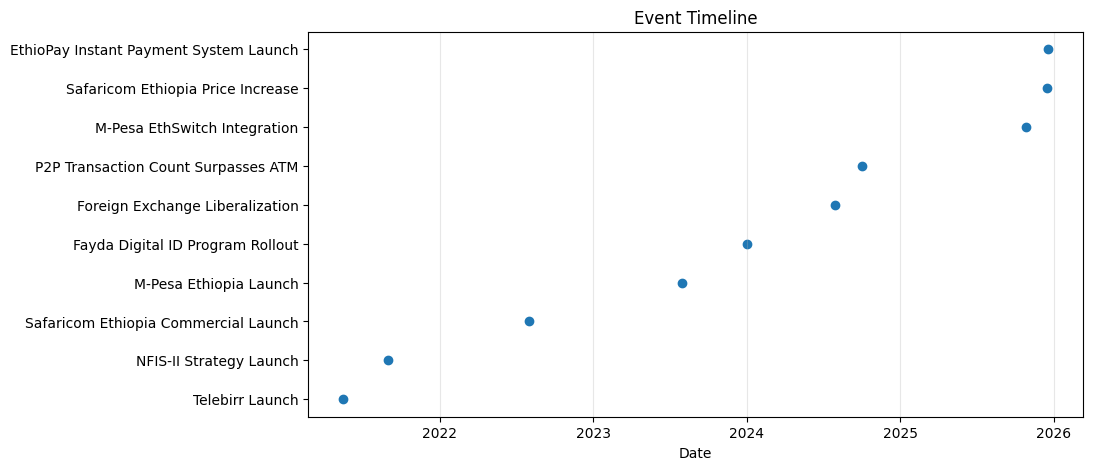

In [18]:
# Build an event table and plot a timeline (by observation_date for event rows)
ev = df[df["record_type"]=="event"].copy()
ev["event_date"] = pd.to_datetime(ev["observation_date"], errors="coerce") if "observation_date" in ev.columns else pd.NaT

show_cols = [c for c in ["record_id","category","indicator","indicator_code","value_text","event_date","source_name","confidence"] if c in ev.columns]
ev = ev.sort_values("event_date")
display(ev[show_cols].reset_index(drop=True))

# Timeline plot (simple)
ev_plot = ev.dropna(subset=["event_date"]).copy()
if not ev_plot.empty:
    plt.figure(figsize=(10, 5))
    y = np.arange(len(ev_plot))
    plt.scatter(ev_plot["event_date"], y)
    plt.yticks(y, ev_plot["indicator"].fillna(ev_plot["indicator_code"]).astype(str))
    plt.title("Event Timeline")
    plt.xlabel("Date")
    plt.grid(True, axis="x", alpha=0.3)
    plt.show()
else:
    print("No event dates available to plot.")


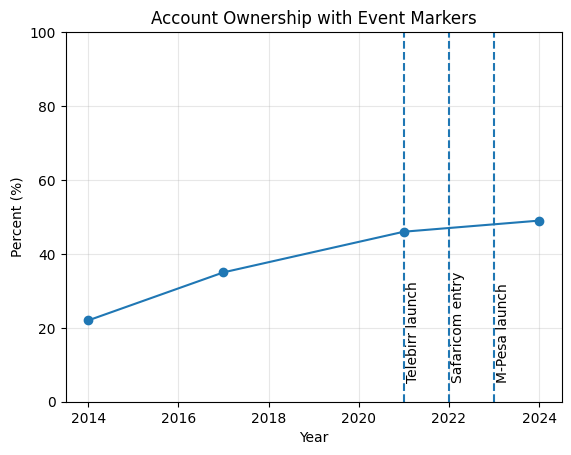

In [19]:
# Overlay key events on Account Ownership chart (vertical lines)
if not acc_nat.empty and not ev_plot.empty:
    plt.figure()
    plt.plot(acc_nat["year"], acc_nat["value_numeric"], marker="o")
    plt.title("Account Ownership with Event Markers")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)

    # Mark major events by year
    major_codes = {"EVT_TELEBIRR":"Telebirr launch", "EVT_SAFARICOM":"Safaricom entry", "EVT_MPESA":"M-Pesa launch"}
    for code, label in major_codes.items():
        e = ev_plot[ev_plot["indicator_code"]==code]
        if not e.empty:
            yr = int(e.iloc[0]["event_date"].year)
            plt.axvline(x=yr, linestyle="--")
            plt.text(yr+0.05, 5, label, rotation=90, va="bottom")

    plt.show()


## 7) Correlation Analysis

In [20]:
# Build a year-level wide table for correlations (observations only)
# Note: correlations are limited by sparse overlap across years.
wide = (obs.dropna(subset=["year","indicator_code","value_numeric"])
        .groupby(["year","indicator_code"])["value_numeric"].mean()
        .reset_index()
        .pivot(index="year", columns="indicator_code", values="value_numeric")
        .sort_index())

display(wide.head(20))

# Correlation matrix (pairwise complete obs)
corr = wide.corr(min_periods=2)
corr_sorted = corr["ACC_OWNERSHIP"].sort_values(ascending=False) if "ACC_OWNERSHIP" in corr.columns else None

if corr_sorted is not None:
    display(corr_sorted.head(15))
    display(corr_sorted.tail(15))
else:
    print("ACC_OWNERSHIP not in correlation table.")


indicator_code,ACC_4G_COV,ACC_FAYDA,ACC_MM_ACCOUNT,ACC_MOBILE_PEN,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,GEN_GAP_MOBILE,GEN_MM_SHARE,USG_ACTIVE_RATE,USG_ATM_COUNT,USG_ATM_VALUE,USG_CROSSOVER,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_P2P_VALUE,USG_TELEBIRR_USERS,USG_TELEBIRR_VALUE
year,,,,,,,,,,,,,,,,,,,
2014,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,NaN,NaN,4.70,NaN,46.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,37.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,NaN,8000000.0,9.45,NaN,49.0,2.0,18.0,24.0,14.0,66.0,NaN,NaN,NaN,7100000.0,10800000.0,49700000.0,NaN,NaN,NaN
2025,70.8,13500000.0,NaN,61.4,NaN,NaN,NaN,NaN,NaN,NaN,119300000.0,1.561000e+11,1.08,NaN,NaN,128300000.0,5.777000e+11,54840000.0,2.380000e+12


indicator_code
ACC_OWNERSHIP       1.0
ACC_MM_ACCOUNT      1.0
GEN_GAP_ACC        -1.0
ACC_4G_COV          NaN
ACC_FAYDA           NaN
ACC_MOBILE_PEN      NaN
AFF_DATA_INCOME     NaN
GEN_GAP_MOBILE      NaN
GEN_MM_SHARE        NaN
USG_ACTIVE_RATE     NaN
USG_ATM_COUNT       NaN
USG_ATM_VALUE       NaN
USG_CROSSOVER       NaN
USG_MPESA_ACTIVE    NaN
USG_MPESA_USERS     NaN
Name: ACC_OWNERSHIP, dtype: float64

indicator_code
ACC_FAYDA            NaN
ACC_MOBILE_PEN       NaN
AFF_DATA_INCOME      NaN
GEN_GAP_MOBILE       NaN
GEN_MM_SHARE         NaN
USG_ACTIVE_RATE      NaN
USG_ATM_COUNT        NaN
USG_ATM_VALUE        NaN
USG_CROSSOVER        NaN
USG_MPESA_ACTIVE     NaN
USG_MPESA_USERS      NaN
USG_P2P_COUNT        NaN
USG_P2P_VALUE        NaN
USG_TELEBIRR_USERS   NaN
USG_TELEBIRR_VALUE   NaN
Name: ACC_OWNERSHIP, dtype: float64

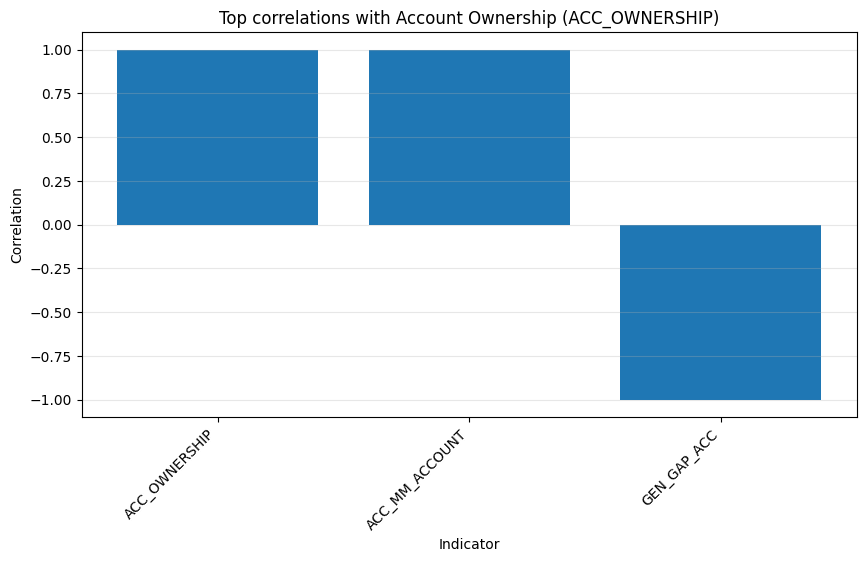

In [21]:
# Plot correlations with ACC_OWNERSHIP if available
if corr_sorted is not None:
    top = corr_sorted.dropna().head(10)
    plt.figure(figsize=(10,5))
    plt.bar(top.index.astype(str), top.values)
    plt.title("Top correlations with Account Ownership (ACC_OWNERSHIP)")
    plt.xlabel("Indicator")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


In [22]:
# What insights emerge from impact_link records? (summary)
links = df[df["record_type"]=="impact_link"].copy()
if not links.empty:
    cols = [c for c in ["parent_id","pillar","related_indicator","impact_direction","impact_magnitude","lag_months","evidence_basis"] if c in links.columns]
    display(links[cols].sort_values(["pillar","impact_magnitude","lag_months"], ascending=[True, False, True]).head(50))
else:
    print("No impact_link records found.")


No impact_link records found.


## 8) Key Insights & Data Limitations (Minimum: 5 insights)
Fill the markdown template below with evidence from the tables/plots above.

### Key insights (with evidence)
1. **Account ownership growth slowed sharply from 2021 to 2024.**  
   - Evidence: `ACC_OWNERSHIP` rises from 46% (2021) to 49% (2024) = +3pp, lower than prior jumps.

2. **Gender gap in account ownership remains large but may be narrowing slightly.**  
   - Evidence: 2021 male 56% vs female 36% (gap 20pp); 2024 estimated gap ~18pp.

3. **Usage-related rails are growing rapidly (P2P transaction growth outpaces ATM growth).**  
   - Evidence: `USG_P2P_COUNT` increases +158% YoY; `USG_ATM_COUNT` +26% YoY; crossover ratio > 1.

4. **Registered vs active account gaps indicate that “accounts opened” ≠ “accounts used.”**  
   - Evidence: `USG_MPESA_USERS` vs `USG_MPESA_ACTIVE` implies ~66% activity rate (example in dataset).

5. **Infrastructure improved substantially (4G coverage nearly doubled), but inclusion gains may lag.**  
   - Evidence: `ACC_4G_COV` from 37.5% (FY2022/23) to 70.8% (FY2024/25) while Findex account ownership only +3pp (2021→2024).

### Why might account ownership stagnate despite mass mobile money registrations?
Hypotheses (to test later with impact models):
- **Overlap**: many mobile money registrants already had accounts; net “unique” account holders rise slowly.
- **Definition**: Findex counts adults who *used* mobile money in the past 12 months; registrations without active use don’t count.
- **Barriers**: rural connectivity/agent access, device constraints, trust, KYC friction, and digital literacy.
- **Market nuance**: P2P dominance may reflect transfers rather than broader financial inclusion use-cases.

### Data gaps / limitations
- Sparse overlap across indicators/years limits correlation strength and causal inference.
- Several indicators have 1–2 observations only (see sparse coverage list).
- Some “calculated” metrics depend on assumptions (document and version control these).
- Some sources may need more precise URLs (operator reports often not directly linked).
